# [OTTO] Easy understanding for beginner (日本語/Eng）

This is the competition hosted by OTTO, which is a famous online-shopping in Germany, and to predict e-commerce clicks, cart additions, and orders.   
Main purpose of this notebook is so that a beginner who join this competition could easily understand how to submit by using what kind of data, and hence please pardon low score.  
Improved points are summarized as below. I'd be happy if it could help you improve your own model even a little bit better (^o^)/

今回のコンペは、ドイツのオンラインショッピング大手OTTO主催のコンペで、ユーザーの「クリック（商品の閲覧）」「カートに入れる」「注文する」を予測するというものです。  
初めてこのコンペに参加する主に初心者の方がどんなデータを使ってどうSubmitすれば良いのかが簡単に分かるようにということで作ったNotebookですので、スコアが低い点はご容赦ください。スコア改善に繋がったような工夫は改善履歴として下表のとおり纏めてありますので、ご自身のモデルにも参考になるような点があれば幸いです。

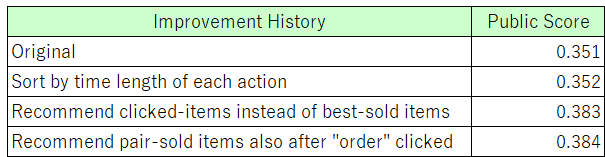


Credit to:  
For Data Loading for JSON  
https://www.kaggle.com/code/edwardcrookenden/otto-getting-started-eda-baseline  
https://www.kaggle.com/code/columbia2131/otto-read-a-chunk-of-jsonl-to-manageable-df  
For Pair items purchased together  
https://www.kaggle.com/code/cdeotte/recommend-items-purchased-together-0-021


# 1. Data Load

In [4]:
import sys
sys.path.append("../..")
import numpy as np
import pandas as pd
from pathlib import Path
from src.configs import DATA_PATH


pd.set_option("display.max_columns", None)

Training data is huge and has 12,899,778 sessions (216,716,095 actions such as clikcs or cart-added), therefore try to download 100k sessions only. (FYI, it'd be easier to understand session as user)   

Trainingデータは、12,899,778セッション（クリック、カートに入れる等のアクション単位だと216,716,095）と巨大なので、10万セッション分だけ取り出します。（このコンペでは「セッション」≒「ユーザー」と考えると分かりやすいと思います）

In [5]:
%%time
sample_size = 100_000

chunks = pd.read_json(DATA_PATH / 'train.jsonl' , lines=True, chunksize = sample_size)

for chunk in chunks :
    train_df = chunk
    break

train_df.set_index('session', drop=True, inplace=True)
train_df

CPU times: user 3.02 s, sys: 692 ms, total: 3.71 s
Wall time: 3.71 s


,events
session,
0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."
...,...
99995,"[{'aid': 1387489, 'ts': 1659326711310, 'type':..."
99996,"[{'aid': 1091948, 'ts': 1659326711396, 'type':..."
99997,"[{'aid': 366639, 'ts': 1659326711431, 'type': ..."


# 2. Sample looking

Let's take a look at one of actual user's actions in a session. We'll see session-4 just as an example.

では、実際にひとつのセッションにおけるユーザーの動きを見てみましょう。例として、セッション４を見てみます。



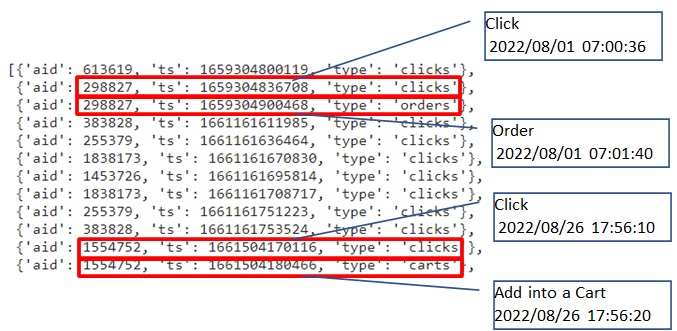

# 3. Create a model

Try to create a model for submission.  
The first idea is to recommend "In-cart items" after 'orders', "Clicked items" after 'carts', though this is very easy idea (that's why the public score is low. LOL!) Recommendation is up to 20 items, hence insufficient items will be supplemented with "best-sold items". Similarly, will recommend "best-sold items" after 'Click' as well.  
The public score from this easy model is **0.351**.  


上記で見たデータ構造をもとに、提出モデルを構築してみます。  
安易ではありますが（だからスコア低いのですが。笑）、「Order」の後には「カートに入れた商品をRecommendしてみる」、「Carts」の後には「クリックした商品をRecommendしてみる」ということをしてみます。20個までRecommendできるので、足りない分は「一番売れている商品」で補充します。  
また、「Click」の後にも「一番売れている商品」をRecommendしてみます。  
この簡易モデルでのスコアは「**0.351**」です。

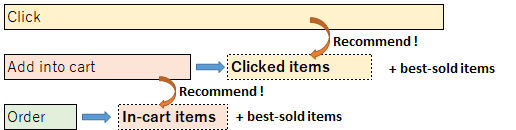

The Dataframe used above was basically same as the original JSON file format. We'll transfer it from section-divided to action-divided so that we could handle it more easily in Pandas.  

これまでに見てみたデータフレームはJSON形式の原データをそのまま読み込んだものですので、Pandasで扱いやすくするためにセッション単位ではなくアクション単位のデータフレームにします。

In [7]:
%%time
train_df = pd.DataFrame()
chunks = pd.read_json(DATA_PATH / 'train.jsonl', lines=True, chunksize=100_000)

i = 0
for chunk in chunks:
    event_dict = {'session': [], 'aid': [], 'ts': [], 'type': []}
    
    for session, events in zip(chunk['session'].tolist(), chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    train_df = pd.DataFrame(event_dict)
    i+=1    
    break
        
train_df = train_df.reset_index(drop=True)
train_df

CPU times: user 8.48 s, sys: 897 ms, total: 9.38 s
Wall time: 9.38 s


,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks
3,0,16246,1659367719997,clicks
4,0,1781822,1659367871344,clicks
...,...,...,...,...
5227648,99999,1544954,1660373630318,clicks
5227649,99999,1032408,1660373656430,clicks
5227650,99999,1544954,1660373678083,clicks
5227651,99999,554230,1660373715477,clicks


Would like to know how long time spent for each action, and create a new column "minutes" where the diff against the next row is set. The timestamp in this competition is 13 digits, which means milli-seconds.

それぞれのアクションに何分消費したかを知るために、minutesのカラムを追加し、次の行との差をセットします。  
このコンペで使われているUnix timestampは13桁ですので、「ミリ秒」を表しています。

In [8]:
train_df["minutes"] = train_df[["session", "ts"]].groupby("session").diff(-1)*(-1/1000/60)
train_df

,session,aid,ts,type,minutes
0,0,1517085,1659304800025,clicks,1.741433
1,0,1563459,1659304904511,clicks,1042.248583
2,0,1309446,1659367439426,clicks,4.676183
3,0,16246,1659367719997,clicks,2.522450
4,0,1781822,1659367871344,clicks,0.240867
...,...,...,...,...,...
5227648,99999,1544954,1660373630318,clicks,0.435200
5227649,99999,1032408,1660373656430,clicks,0.360883
5227650,99999,1544954,1660373678083,clicks,0.623233
5227651,99999,554230,1660373715477,clicks,0.172533


Create best-sold item's list.  

Best-sold商品のリストを作っています。

In [9]:
temp = train_df.groupby(['type','aid'])['session'].agg('count').reset_index()
temp.columns = ['type','aid','count']
order_num_df = temp.loc[(temp['type'] == 'orders'), ]
order_num_df = order_num_df.sort_values(['count'],ascending=False).reset_index()
order_num_df

,index,type,aid,count
0,812656,orders,80222,127
1,840266,orders,1022566,106
2,815207,orders,166037,94
3,858211,orders,1629608,76
4,861353,orders,1733943,75
...,...,...,...,...
54751,831592,orders,727990,1
54752,831593,orders,728010,1
54753,831594,orders,728086,1
54754,831595,orders,728208,1


In [10]:
order_num_df.aid = ' ' + order_num_df.aid.astype('str')
best_sold_list = order_num_df[:20].aid.sum()
best_sold_list

' 80222 1022566 166037 1629608 1733943 332654 351335 923948 1603001 544144 1083665 832192 29735 231487 563117 247240 673407 125278 800391 527209'

Download Test-data.  

テストデータをダウンロードします。

In [12]:
test_df = pd.DataFrame()
chunks = pd.read_json(DATA_PATH / 'test.jsonl', lines=True, chunksize=100_000)

for chunk in chunks:
    event_dict = {'session': [],'aid': [],'ts': [],'type': []}
    for session, events in zip(chunk['session'].tolist(), chunk['events'].tolist()):
        for event in events:
            event_dict['session'].append(session)
            event_dict['aid'].append(event['aid'])
            event_dict['ts'].append(event['ts'])
            event_dict['type'].append(event['type'])
    chunk_session = pd.DataFrame(event_dict)
    test_df = pd.concat([test_df, chunk_session])
            
test_df = test_df.reset_index(drop=True)
test_df

,session,aid,ts,type
0,12899779,59625,1661724000278,clicks
1,12899780,1142000,1661724000378,clicks
2,12899780,582732,1661724058352,clicks
3,12899780,973453,1661724109199,clicks
4,12899780,736515,1661724136868,clicks
...,...,...,...,...
6928118,14571577,1141710,1662328774770,clicks
6928119,14571578,519105,1662328775009,clicks
6928120,14571579,739876,1662328775605,clicks
6928121,14571580,202353,1662328781067,clicks


Similarly to Train-data, add a new column "minutes".  
Sorting by descending "minutes", public score was a bit improved from 0.351 to **0.352**.
I guess it'd be better to recommend the items watched longer time (^o^)/


Trainデータ同様、minutesのカラムを追加します。  
ここで、時間の長い順からソートすることで、スコアが僅かながら改善しました。（0.351 --> **0.352**)
やはり、長い間見ている商品ほどRecommendしたほうがよいのでしょうか (^o^)/

In [13]:
%%time
test_df["minutes"] = test_df[["session", "ts"]].groupby("session").diff(-1)*(-1/1000/60)
test_df = test_df.sort_values(['minutes'],ascending=False)

test_action_df = test_df.copy()
test_action_df.aid = ' ' + test_df.aid.astype('str')
test_action_df = test_action_df.groupby(['session','type'])['aid'].sum().reset_index()
test_action_df

CPU times: user 4min 21s, sys: 1.85 s, total: 4min 23s
Wall time: 4min 23s


,session,type,aid
0,12899779,clicks,59625
1,12899780,clicks,1142000 582732 973453 736515 1142000
2,12899781,carts,199008
3,12899781,clicks,199008 194067 199008 199008 199008 199008 573...
4,12899782,carts,1494780 834354 975116 127404 413962 595994 13...
...,...,...,...
1948868,14571577,clicks,1141710
1948869,14571578,clicks,519105
1948870,14571579,clicks,739876
1948871,14571580,clicks,202353


In [14]:
# Use action type 'carts' to predict 'orders'
next_orders_df = pd.DataFrame(test_action_df.loc[(test_action_df["type"] == 'carts'), ])
next_orders_df['type'] = 'orders'
next_orders_df

,session,type,aid
2,12899781,orders,199008
4,12899782,orders,1494780 834354 975116 127404 413962 595994 13...
10,12899786,orders,955252
12,12899787,orders,1682750 1682750 1682750
16,12899790,orders,1830166 1219653
...,...,...,...
1948716,14571430,orders,903014
1948730,14571443,orders,942326
1948774,14571486,orders,350578
1948788,14571499,orders,1132907


In [15]:
# Use action type 'clicks' to predict 'carts'
next_carts_df = pd.DataFrame(test_action_df.loc[(test_action_df["type"] == 'clicks'), ])
next_carts_df['type'] = 'carts'
next_carts_df

,session,type,aid
0,12899779,carts,59625
1,12899780,carts,1142000 582732 973453 736515 1142000
3,12899781,carts,199008 194067 199008 199008 199008 199008 573...
5,12899782,carts,603159 779477 1299062 602722 413962 975116 16...
7,12899783,carts,607638 1729553 255297 300127 1754419 1216820 ...
...,...,...,...
1948868,14571577,carts,1141710
1948869,14571578,carts,519105
1948870,14571579,carts,739876
1948871,14571580,carts,202353


For Clicks, changed the recommendation items from 'best-sold item' to 'clicked item', which improved the public score from 0.352 to **0.383**. It seems better to recommend items which user once clicked(=show his/her interest) rather than best-sold items which may has nothing to do with him/her.  

クリックの後にはbest-sold itemをrecommendしていたのですが、代わりに「クリックした商品」をrecommendしたら、スコアは0.352から**0.383**へと結構大きく改善しました。やはり、興味とは全然関係ない商品群を見せられるより自分が一度はクリックした商品をあらためてRecommendしたほうが良いみたいです。

In [16]:
next_clicks_df = pd.DataFrame(test_action_df.loc[(test_action_df["type"] == 'clicks'), ]).copy()

In [17]:
recommend_df = pd.concat([next_orders_df, next_carts_df, next_clicks_df], axis =0)
recommend_df["session_type"] = recommend_df["session"].astype('str') + "_" + recommend_df["type"] 
recommend_df

,session,type,aid,session_type
2,12899781,orders,199008,12899781_orders
4,12899782,orders,1494780 834354 975116 127404 413962 595994 13...,12899782_orders
10,12899786,orders,955252,12899786_orders
12,12899787,orders,1682750 1682750 1682750,12899787_orders
16,12899790,orders,1830166 1219653,12899790_orders
...,...,...,...,...
1948868,14571577,clicks,1141710,14571577_clicks
1948869,14571578,clicks,519105,14571578_clicks
1948870,14571579,clicks,739876,14571579_clicks
1948871,14571580,clicks,202353,14571580_clicks


In [19]:
sample_sub = pd.read_csv(DATA_PATH / 'sample_submission.csv')
sample_sub

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524
...,...,...
5015404,14571580_carts,129004 126836 118524
5015405,14571580_orders,129004 126836 118524
5015406,14571581_clicks,129004 126836 118524
5015407,14571581_carts,129004 126836 118524


In [20]:
sample_sub = pd.merge(sample_sub, recommend_df[["session_type","aid"]], on = "session_type", how ="left")
sample_sub['next'] = sample_sub['aid']
sample_sub['next'].fillna('', inplace = True)
# sample_sub['next'] = sample_sub['aid'] + best_sold_list
# sample_sub['next'].fillna(best_sold_list, inplace = True)
sample_sub['next'] = sample_sub['next'].str.strip()
sample_sub = sample_sub.drop(["labels", "aid"], axis = 1)
sample_sub.columns = ("session_type", "labels")
sample_sub

,session_type,labels
0,12899779_clicks,59625
1,12899779_carts,59625
2,12899779_orders,
3,12899780_clicks,1142000 582732 973453 736515 1142000
4,12899780_carts,1142000 582732 973453 736515 1142000
...,...,...
5015404,14571580_carts,202353
5015405,14571580_orders,
5015406,14571581_clicks,1100210
5015407,14571581_carts,1100210


In [24]:
sample_sub['labels_count'] = sample_sub['labels'].apply(lambda x: len(x.split(' ')))
sample_sub

,session_type,labels,labels_count
0,12899779_clicks,59625,1
1,12899779_carts,59625,1
2,12899779_orders,,1
3,12899780_clicks,1142000 582732 973453 736515 1142000,5
4,12899780_carts,1142000 582732 973453 736515 1142000,5
...,...,...,...
5015404,14571580_carts,202353,1
5015405,14571580_orders,,1
5015406,14571581_clicks,1100210,1
5015407,14571581_carts,1100210,1


In [25]:
sample_sub[sample_sub['labels_count']>20]

,session_type,labels,labels_count
9,12899782_clicks,603159 779477 1299062 602722 413962 975116 166...,46
10,12899782_carts,603159 779477 1299062 602722 413962 975116 166...,46
18,12899785_clicks,258458 1308865 587969 383003 970225 1154962 11...,102
19,12899785_carts,258458 1308865 587969 383003 970225 1154962 11...,102
90,12899809_clicks,703890 637593 637593 963478 385521 118631 6375...,30
...,...,...,...
5010553,14569963_carts,1059846 1334511 647374 933458 1334511 1334511 ...,34
5012028,14570455_clicks,225566 932386 718019 1539511 706242 1757032 17...,31
5012029,14570455_carts,225566 932386 718019 1539511 706242 1757032 17...,31
5012208,14570515_clicks,1521766 125988 473057 1755952 1257340 754951 1...,21


In [21]:
sample_sub.to_csv('submission.csv', index=False)

# 4. Add 'pair-sold' items

If you submit the csv here, the score will show 0.383.  
Trying to do something for more improvement, try to add pair-sold items list (= other items ordered at the same time when a certain item was ordered).  
The image is, when A was ordered 'B,C,D' were also ordered at the same time, 'B,C,D' could be regarded as pair-sold items for A.  
This contributed the slight score improvement from 0.383 to **0.384**.

ここでSubmitすると、スコアは0.383です。  
もう少し何かできないかということで、「ついで買い」した商品のリストもrecommendationに加えてみます。  
Aという商品がOrderされた際にB、C、Dという商品もOrderされている場合、「B,C,D」をAのついで買い商品としてリスト化するものです。  
これを追加することで、スコアは0.383→**0.384**へと少し改善しました。

In [16]:
train_order_df = train_df.loc[(train_df["type"] == 'orders'),].copy()
aid_counts = train_df.aid.value_counts()
aid_counts

29735      3716
832192     3299
1733943    3046
108125     2900
1603001    2863
           ... 
1346268       1
606579        1
1298735       1
1023270       1
662215        1
Name: aid, Length: 663079, dtype: int64

In [17]:
pairs = {}
for i in aid_counts.index.values[:10000]:
    
    custs = train_order_df.loc[train_order_df.aid==i.item(),'session'].unique()
    aid_orders = train_order_df.loc[(train_order_df.session.isin(custs))&(train_order_df.aid!=i.item()),'aid'].value_counts()   
    try :
        pairs[i.item()] = [aid_orders.index[0], aid_orders.index[1], aid_orders.index[2]]
    except :
        continue

In [18]:
pairs_df = pd.DataFrame(pairs)
pairs_df = pairs_df.T
pairs_df['aid'] = pairs_df.index
pairs_df['3pairs'] =' '+pairs_df[0].astype('str')+' '+pairs_df[1].astype('str')+' '+pairs_df[2].astype('str')
pairs_df

,0,1,2,aid,3pairs
29735,832192,619885,231487,29735,832192 619885 231487
832192,298888,1691100,29735,832192,298888 1691100 29735
1733943,536184,1457252,680985,1733943,536184 1457252 680985
108125,1503,329725,1492204,108125,1503 329725 1492204
1603001,80222,1472383,101118,1603001,80222 1472383 101118
...,...,...,...,...,...
1171179,1716596,714968,669218,1171179,1716596 714968 669218
778291,1847859,558296,254154,778291,1847859 558296 254154
1203675,1384753,248962,495779,1203675,1384753 248962 495779
990697,1288196,1167802,1609126,990697,1288196 1167802 1609126


In [19]:
test_orders_df = pd.DataFrame(test_df.loc[(test_df["type"] == 'carts'), ]).copy()
test_orders_df = pd.merge(test_orders_df, pairs_df[['aid','3pairs']], on = 'aid', how = 'left')
test_orders_df['type'] = 'orders'
test_orders_df['aid'] = ' ' + test_orders_df['aid'].astype('str')
test_orders_df

,session,aid,ts,type,minutes,3pairs
0,12905715,1531805,1661727521491,orders,9954.876183,674295 436764 84886
1,12908612,755467,1661731587214,orders,9875.326483,NaN
2,12914996,471073,1661746910460,orders,9630.287600,532024 340205 904917
3,12909406,631155,1661734150961,orders,9591.169100,1588316 641790 1253946
4,12911707,1662401,1661740775890,orders,9484.075567,443425 488528 125957
...,...,...,...,...,...,...
570006,14571335,1731301,1662328716651,orders,NaN,NaN
570007,14571341,1441093,1662328573060,orders,NaN,1480985 1786188 1705711
570008,14571393,447242,1662328683124,orders,NaN,196039 835431 457623
570009,14571486,350578,1662328680320,orders,NaN,NaN


In [20]:
next_orders_df = test_orders_df.groupby(['session','type'])[['aid','3pairs']].sum().reset_index()
next_orders_df = next_orders_df.replace(0, ' ')
next_orders_df['aid'] = next_orders_df['aid'] + next_orders_df['3pairs']
next_orders_df = next_orders_df.drop(['3pairs'], axis = 1)

recommend_df = pd.concat([next_orders_df, next_carts_df, next_clicks_df], axis =0)
recommend_df["session_type"] = recommend_df["session"].astype('str') + "_" + recommend_df["type"] 
recommend_df

,session,type,aid,session_type
0,12899781,orders,199008,12899781_orders
1,12899782,orders,1494780 834354 975116 127404 413962 595994 13...,12899782_orders
2,12899786,orders,955252,12899786_orders
3,12899787,orders,1682750 1682750 1682750,12899787_orders
4,12899790,orders,1830166 1219653,12899790_orders
...,...,...,...,...
1948868,14571577,clicks,1141710,14571577_clicks
1948869,14571578,clicks,519105,14571578_clicks
1948870,14571579,clicks,739876,14571579_clicks
1948871,14571580,clicks,202353,14571580_clicks


# 5. Submission

In [22]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub = pd.merge(sample_sub, recommend_df[["session_type","aid"]], on = "session_type", how ="left")
sample_sub['next'] = sample_sub['aid'] + best_sold_list
sample_sub['next'].fillna(best_sold_list, inplace = True)
sample_sub['next'] = sample_sub['next'].str.strip()
sample_sub = sample_sub.drop(["labels", "aid"], axis = 1)
sample_sub.columns = ("session_type", "labels")
sample_sub.to_csv('submission.csv', index=False)

In [ ]:
sample_sub